# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Reading and inspecting the data

In [3]:
df = pd.read_csv('day.csv')

In [4]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Dropping columns not required

We can drop the below columns:
1. instant - This column is a serial number of the data frame and we can safely drop this
2. dteday - Since we already have the information for yr, month and weekday, we can drop the date column
3. casual and registered - These are highly correlated with our target variable(cnt) since casual + registered = cnt. In essence, we can build our model using any of these features (casual or registered or cnt) as a target variable.

In [5]:
df.drop(columns=['instant','dteday','casual','registered'], inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [6]:
df.shape

(730, 12)

In [7]:
# Inspecting the columns and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [8]:
# Checking missing values

df.isna().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

We have 730 records comprising of 2 years data. Also, there are no missing values in the data. 

In [9]:
df[['temp','atemp','hum','windspeed','cnt']].describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


The mean and median are close to each other for all the continuous variables. 

The minimum value for hum is zero which is impossible. We will investigate it more as it seems to be outlier.

# Data Cleaning

We will map Season, mnth, weekday, weathersit columns to their values to analyse and create dummy variables in a more meaningful way. For other categorical columns, the values are binary and we dont need to perform one hot encoding for these variables. 

In [10]:
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [11]:
df.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [12]:
df.weathersit = df.weathersit.map({1: 'Clear', 
                                   2: 'Mist + Cloudy',
                                   3: 'Light Snow + Light Rain',
                                   4: 'Heavy Rain + Ice Pallets'})

In [13]:
df.weathersit.value_counts()

Clear                      463
Mist + Cloudy              246
Light Snow + Light Rain     21
Name: weathersit, dtype: int64

In [14]:
df.mnth = df.mnth.map({1:'Jan',
                       2:'Feb',
                       3:'Mar',
                       4:'Apr',
                       5:'May',
                       6:'Jun',
                       7:'Jul',
                       8:'Aug',
                       9:'Sep',
                       10:'Oct',
                       11:'Nov',
                       12:'Dec'
                      })

In [15]:
df.mnth.value_counts()

May    62
Jan    62
Dec    62
Oct    62
Jul    62
Aug    62
Mar    62
Jun    60
Sep    60
Nov    60
Apr    60
Feb    56
Name: mnth, dtype: int64

In [16]:
df.weekday = df.weekday.map({1:'Mon',
                             2:'Tue',
                             3:'Wed',
                             4:'Thu',
                             5:'Fri',
                             6:'Sat',
                             0:'Sun'                            
                            })

In [17]:
df.weekday.value_counts()

Tue    105
Mon    105
Thu    104
Fri    104
Sat    104
Wed    104
Sun    104
Name: weekday, dtype: int64

In [18]:
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,Dec,0,Fri,1,Mist + Cloudy,10.420847,11.33210,65.2917,23.458911,2114
726,spring,1,Dec,0,Sat,0,Mist + Cloudy,10.386653,12.75230,59.0000,10.416557,3095
727,spring,1,Dec,0,Sun,0,Mist + Cloudy,10.386653,12.12000,75.2917,8.333661,1341
728,spring,1,Dec,0,Mon,1,Clear,10.489153,11.58500,48.3333,23.500518,1796


Lets check the correlation between temp and atemp

In [19]:
df[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


As expected, we can see that temp and atemp has a very high correlation. We can drop one of the columns

In [20]:
# dropping atemp

df.drop(columns='atemp', inplace=True)

In [21]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


# Exploratory Data Analysis

### Numerical features

In [22]:
df[['temp','hum','windspeed']].describe()

,temp,hum,windspeed
count,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620
std,7.506729,14.237589,5.195841
min,2.424346,0.000000,1.500244
25%,13.811885,52.000000,9.041650
50%,20.465826,62.625000,12.125325
75%,26.880615,72.989575,15.625589
max,35.328347,97.250000,34.000021


Lets look at the distribution of the numerical features

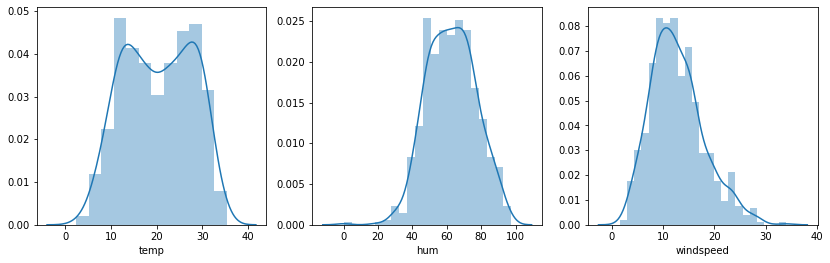

In [23]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.distplot(df.temp)

plt.subplot(1,3,2)
sns.distplot(df.hum)

plt.subplot(1,3,3)
sns.distplot(df.windspeed)
plt.show()

The numerical features are almost normally distributed. 

#### Outlier Analysis

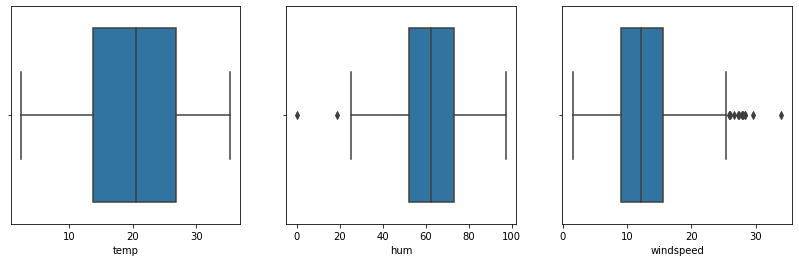

In [24]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.boxplot(df.temp)

plt.subplot(1,3,2)
sns.boxplot(df.hum)

plt.subplot(1,3,3)
sns.boxplot(df.windspeed)
plt.show()

Boxplots show that there might be a few outliers for hum and windspeed. However, because the dataset is comparatively small with just 730 rows, we will not remove or cap the outliers

But the hum column has a zero value which is impossible. We will need to verify this.

In [25]:
df[df.hum == 0]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
68,spring,0,Mar,0,Sat,0,Light Snow + Light Rain,15.952731,0.0,17.545759,623


Since there is only 1 row with hum = 0, we can delete this row 

In [26]:
df.drop(df[df.hum==0].index, inplace=True)

In [27]:
df.hum.describe()

count    729.000000
mean      62.851273
std       14.055910
min       18.791700
25%       52.000000
50%       62.666700
75%       73.000000
max       97.250000
Name: hum, dtype: float64

#### Pair plots

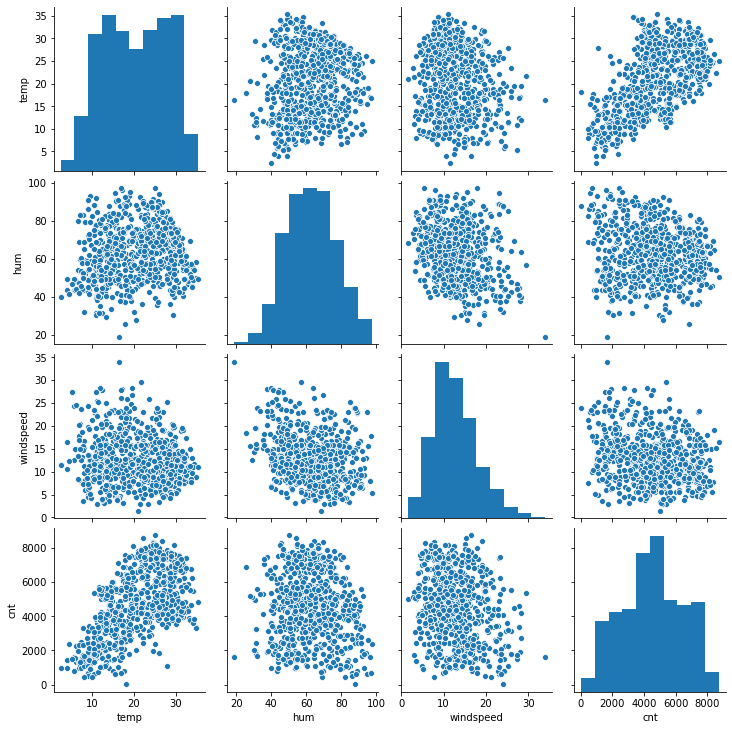

In [28]:
sns.pairplot(df[['temp', 'hum', 'windspeed','cnt']])
plt.show()

Among the numerical features, temp has the highest correlation with the target variable cnt

### Categorical features

In [29]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


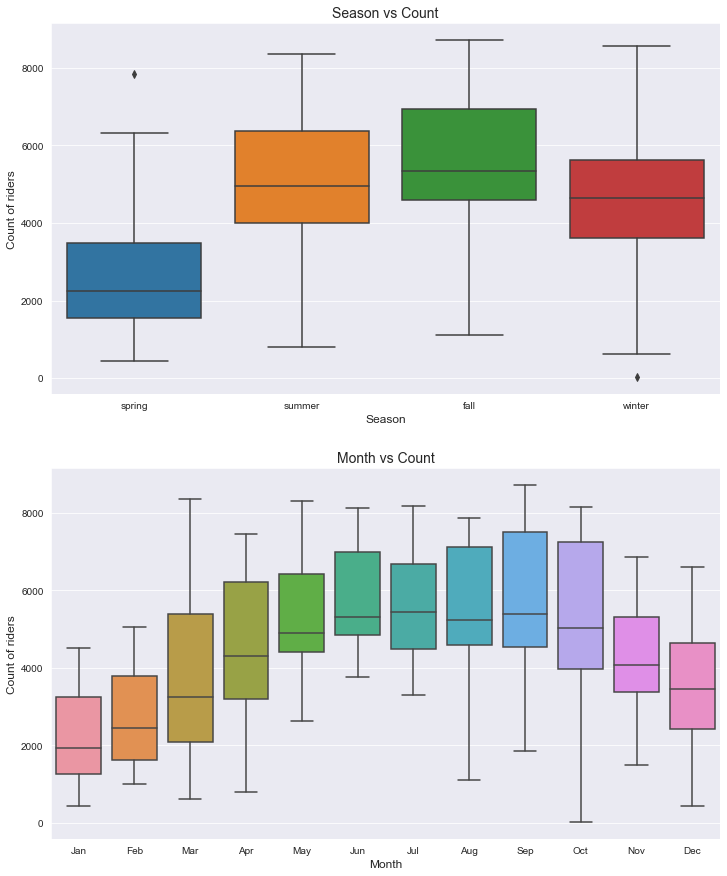

In [30]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,15))

plt.subplot(2,1,1)
sns.boxplot(x=df.season, y=df.cnt)
plt.xlabel('Season', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Season vs Count', size=14)

plt.subplot(2,1,2)
sns.boxplot(x=df.mnth, y=df.cnt)
plt.xlabel('Month', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Month vs Count', size=14)
plt.show()

The median number of riders is the minimum for spring season. The median number of riders for summer, fall and winter are almost same and is considerably higher compared to spring. However, the median and the range of count of riders for fall is slightly higher than summer and winter. 

We can infer that fall season seems to be the most lucrative time for bike riders followed by summer and winter. Spring seems to be the least lucrative season. 

When we look at the distribution of riders across months, a similar trend appears where the median number of riders increases from January to June and then it stabilizes till around September before decreasing from October to December. However, one observation that we see among months is that March has a very high range of count of riders compared to other spring months. We observe a similar pattern for October as well.

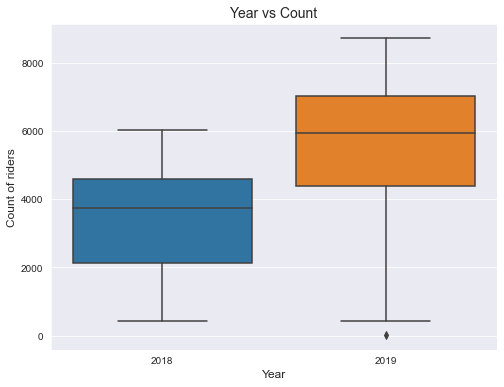

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(df.yr, df.cnt)
plt.xticks([0,1],[2018,2019])
plt.xlabel('Year', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Year vs Count', size=14)
plt.show()

We can infer that year plays a very crucial role in the number of riders. From 2018 to 2019 the range of count of riders has increased drastically. In fact the median number of riders in 2019 is almost equal to the maximum riders in 2018.

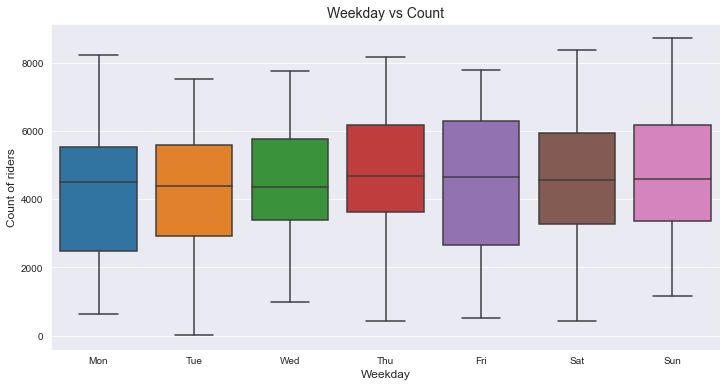

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(df.weekday, df.cnt)
plt.xlabel('Weekday', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Weekday vs Count', size=14)
plt.show()

Almost all days of the week have similar range of count of riders with a similar median number of riders for all days. Saturday and Sunday seem to have a slightly higher range though it’s not very significant.

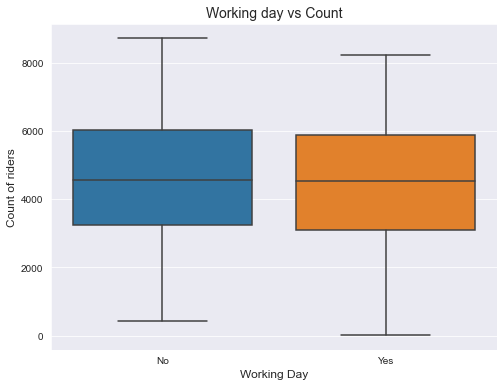

In [33]:
plt.figure(figsize=(8,6))
sns.boxplot(df.workingday, df.cnt)
plt.xticks([0,1],['No','Yes'])
plt.xlabel('Working Day', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Working day vs Count', size=14)
plt.show()

For both working and non-working day, the median number of riders is almost same. However, the range for count of riders for non-working day is slightly higher

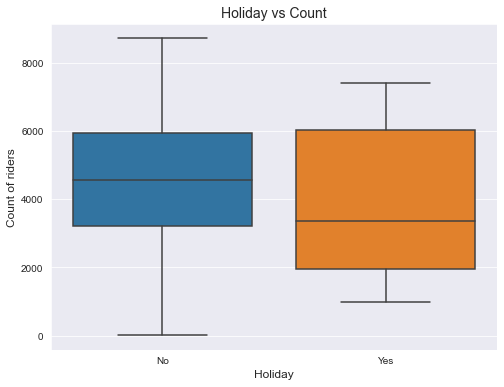

In [34]:
plt.figure(figsize=(8,6))
sns.boxplot(df.holiday, df.cnt)
plt.xticks([0,1],['No','Yes'])
plt.xlabel('Holiday', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Holiday vs Count', size=14)
plt.show()

The median number of riders and the range of count of riders for a non-holiday are higher compared to a holiday. However, we can see that on holidays the range of count of riders in the 25th to 75th percentile is much more comparatively

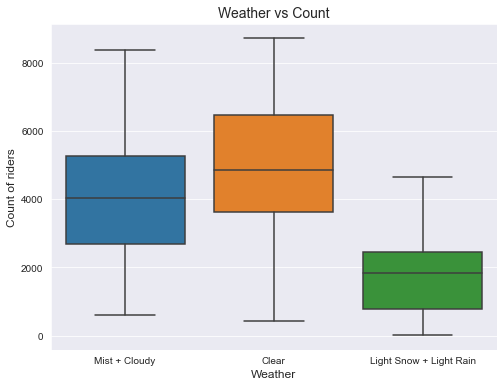

In [35]:
plt.figure(figsize=(8,6))
sns.boxplot(df.weathersit, df.cnt)
plt.xlabel('Weather', size=12)
plt.ylabel('Count of riders', size=12)
plt.title('Weather vs Count', size=14)
plt.show()

Clear weather has the highest median count of riders as we can expect. This is followed by mist and cloudy weather. The range of count of riders for both clear and cloudy weather is similar. 

However, the median number of riders as well as the range of count of riders is comparatively much less when the weather is light snow or light rain.

### Correlation analysis

In [36]:
corr_matrix = df.corr()

In [37]:
corr_matrix

,yr,holiday,workingday,temp,hum,windspeed,cnt
yr,1.000000,0.007965,-0.013931,0.048035,-0.120296,-0.010374,0.568939
holiday,0.007965,1.000000,-0.257761,-0.028909,-0.016931,0.006478,-0.069432
workingday,-0.013931,-0.257761,1.000000,0.000853,0.045412,-0.000568,-0.031890
temp,0.048035,-0.028909,0.000853,1.000000,0.126775,-0.157579,0.627323
hum,-0.120296,-0.016931,0.045412,0.126775,1.000000,-0.246385,-0.112514
windspeed,-0.010374,0.006478,-0.000568,-0.157579,-0.246385,1.000000,-0.233377
cnt,0.568939,-0.069432,-0.031890,0.627323,-0.112514,-0.233377,1.000000


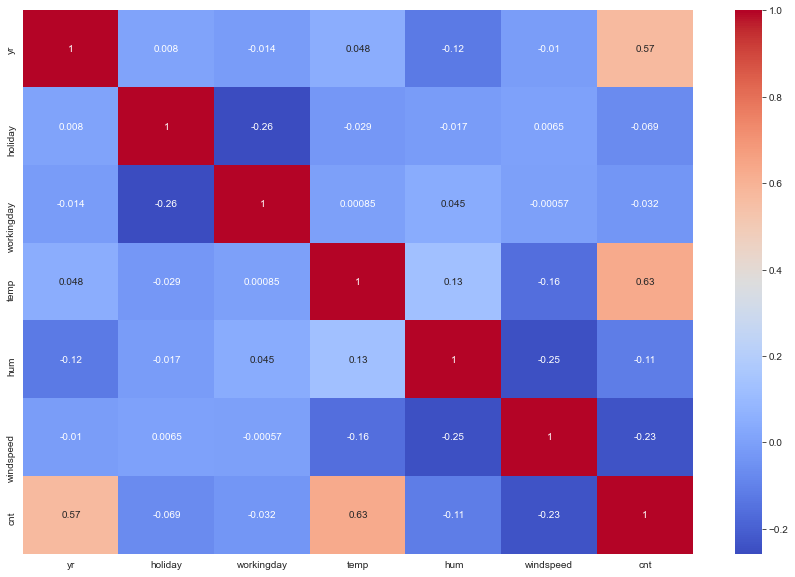

In [38]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

year and temp have a high correlation with our target variable. 

Also, working day and holiday are correlated though not very strongly. Similarly, windspeed is correlated with temp and hum. 
We will look into correlation further while building our model to check for multicollinearity. 

# Encoding Categorical variables

In [39]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,1,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


yr, holiday, workingday are binary categorical variables. For season, mnth, weekday, weathersit we will perform one hot encoding using dummy variables

In [40]:
df = pd.get_dummies(df, columns=['season','mnth','weekday','weathersit'], drop_first=True)
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow + Light Rain,weathersit_Mist + Cloudy
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Light Snow + Light Rain',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [42]:
# Lets look at the shape now

df.shape

(729, 29)

# Train Test Split

In [43]:
df_train, df_test = train_test_split(df, test_size = .3, random_state = 42)

In [44]:
df_train.shape

(510, 29)

In [45]:
df_test.shape

(219, 29)

# Feature Scaling

We will perform MinMax scaling to normalize all values to the same scale of [0,1]

We will fit_transform on the training data and then transform on the test data. We do this in order to prevent data leakage.

In [46]:
scaler = MinMaxScaler()

In [47]:
num_features = ['temp','hum','windspeed','cnt']
df_train[num_features]

,temp,hum,windspeed,cnt
683,13.188347,62.0417,10.250129,5445
645,15.716653,70.9583,12.708493,5478
164,24.770847,50.7083,18.041961,4891
361,12.264330,50.3913,19.695387,2302
640,26.957500,79.3750,4.458569,7572
...,...,...,...,...
72,13.333897,49.6957,9.174042,2046
107,21.012500,54.2500,10.958989,3429
271,25.283347,69.9167,11.583161,4839
436,23.165000,61.7500,15.875650,5847


In [48]:
df_train[num_features] = scaler.fit_transform(df_train[num_features])

In [49]:
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow + Light Rain,weathersit_Mist + Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.521569,0.031373,0.682353,0.551737,0.529718,0.414056,0.503985,0.233333,0.256863,0.24902,...,0.090196,0.090196,0.133333,0.143137,0.147059,0.145098,0.152941,0.135294,0.023529,0.339216
std,0.500025,0.174494,0.466018,0.226833,0.193899,0.188171,0.234894,0.423368,0.437332,0.43287,...,0.286744,0.286744,0.340268,0.350557,0.354512,0.352545,0.360284,0.342373,0.151726,0.473908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354526,0.376235,0.280374,0.349300,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.574785,0.534031,0.383964,0.509175,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.745598,0.673938,0.527200,0.689032,0.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Creating X and y for model building

In [50]:
y_train = df_train.pop('cnt')
X_train = df_train

In [51]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow + Light Rain,weathersit_Mist + Cloudy
683,1,0,1,0.327133,0.511344,0.327101,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
645,1,1,0,0.403972,0.635834,0.419004,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
164,0,0,1,0.679142,0.353111,0.618387,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
361,0,0,1,0.299051,0.348686,0.680198,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640,1,0,1,0.745598,0.753345,0.110593,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1


In [52]:
X_train.shape

(510, 28)

In [53]:
y_train.head()

683    0.605336
645    0.609320
164    0.538452
361    0.225884
640    0.862127
Name: cnt, dtype: float64

# Model Building

### RFE

Currently, we have 28 Predictors to Predict our outcome. Analysing these many predictors can be very hectic.
To simplify this process, we will use RFE (Recursive Feature Elimination) method.

We will first build the model using scikit learn's Linear Regression. We are doing this so that we can use sklearn's RFE to create the model with the most useful features before manually checking them in the model

In [54]:
# Running RFE with number of columns as 15

model = LinearRegression()
model.fit(X_train,y_train)

rfe = RFE(model, 15)
rfe = rfe.fit(X_train, y_train)

In [55]:
# Creating a list of features with their support and ranking. Ranking of 1 means the feature is selected for the model building

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', False, 6),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 12),
 ('season_winter', False, 2),
 ('mnth_Aug', False, 13),
 ('mnth_Dec', False, 4),
 ('mnth_Feb', False, 11),
 ('mnth_Jan', False, 9),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 10),
 ('mnth_Mar', True, 1),
 ('mnth_May', True, 1),
 ('mnth_Nov', False, 3),
 ('mnth_Oct', True, 1),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 5),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 14),
 ('weekday_Tue', False, 7),
 ('weekday_Wed', False, 8),
 ('weathersit_Light Snow + Light Rain', True, 1),
 ('weathersit_Mist + Cloudy', True, 1)]

In [56]:
cols = X_train.columns[rfe.support_]
cols

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'mnth_Jul', 'mnth_Mar', 'mnth_May', 'mnth_Oct', 'mnth_Sep',
       'weekday_Sat', 'weekday_Sun', 'weathersit_Light Snow + Light Rain',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [57]:
# Creating X_train based on the rfe selected features
X_train_rfe = X_train[cols]
X_train_rfe.head()

,yr,workingday,temp,hum,windspeed,season_spring,mnth_Jul,mnth_Mar,mnth_May,mnth_Oct,mnth_Sep,weekday_Sat,weekday_Sun,weathersit_Light Snow + Light Rain,weathersit_Mist + Cloudy
683,1,1,0.327133,0.511344,0.327101,0,0,0,0,0,0,0,0,0,1
645,1,0,0.403972,0.635834,0.419004,0,0,0,0,1,0,0,0,0,1
164,0,1,0.679142,0.353111,0.618387,0,0,0,0,0,0,0,0,0,0
361,0,1,0.299051,0.348686,0.680198,1,0,0,0,0,0,0,0,0,0
640,1,1,0.745598,0.753345,0.110593,0,0,0,0,1,0,0,0,0,1


### Building a model with more statistical summary using statsmodel

In [58]:
X_train_sm = sm.add_constant(X_train_rfe)

model = sm.OLS(y_train, X_train_sm).fit()

In [59]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     173.7
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          7.18e-186
Time:                        22:20:19   Log-Likelihood:                 483.89
No. Observations:                 510   AIC:                            -935.8
Df Residuals:                     494   BIC:                            -868.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [60]:
# Function to calculate the VIF for the training features

def getvif(train_data):
    vif = pd.DataFrame()
    vif['Features'] = train_data.columns
    vif['VIF'] = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(inplace=True, drop=True)
    return vif

In [61]:
# Calculate the VIFs for the new model

getvif(X_train_rfe)

,Features,VIF
0,hum,14.82
1,temp,14.31
2,workingday,13.65
3,windspeed,5.76
4,weekday_Sun,3.56
5,weekday_Sat,3.55
6,weathersit_Mist + Cloudy,2.49
7,season_spring,2.21
8,yr,2.06
9,mnth_Jul,1.64


A VIF value of more than 5 indicates high collinearity of the associated predictor variable with other preditors.

hum with a VIF > 5 is highly collinear with other variables.

We will drop this feature and rebuild our model

In [62]:
X_train_rfe.drop('hum', axis=1, inplace=True)

In [63]:
X_train_sm = sm.add_constant(X_train_rfe)

model2 = sm.OLS(y_train, X_train_sm).fit()

In [64]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.5
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          4.20e-182
Time:                        22:20:19   Log-Likelihood:                 472.19
No. Observations:                 510   AIC:                            -914.4
Df Residuals:                     495   BIC:                            -850.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [65]:
getvif(X_train_rfe)

,Features,VIF
0,temp,12.28
1,workingday,10.95
2,windspeed,5.57
3,weekday_Sun,3.11
4,weekday_Sat,3.08
5,season_spring,2.11
6,yr,2.05
7,mnth_Jul,1.61
8,weathersit_Mist + Cloudy,1.58
9,mnth_Sep,1.32


mnth_May is insignificant for our model as it has a p-value > .05

We will drop this feature and rebuild our model

In [66]:
X_train_rfe.drop('mnth_May', axis=1, inplace=True)

In [67]:
X_train_sm = sm.add_constant(X_train_rfe)

model3 = sm.OLS(y_train, X_train_sm).fit()

In [68]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     189.0
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.49e-182
Time:                        22:20:19   Log-Likelihood:                 470.53
No. Observations:                 510   AIC:                            -913.1
Df Residuals:                     496   BIC:                            -853.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [69]:
getvif(X_train_rfe)

,Features,VIF
0,temp,11.86
1,workingday,10.93
2,windspeed,5.55
3,weekday_Sun,3.11
4,weekday_Sat,3.08
5,season_spring,2.09
6,yr,2.05
7,weathersit_Mist + Cloudy,1.57
8,mnth_Jul,1.51
9,mnth_Sep,1.26


We can see that the VIF for temp, workingday, windspeed is higher than 5. But looking at our correlation matrix, temp is highly correlated with our target variable. 

We will drop workingday and rebuild our model

In [70]:
X_train_rfe.drop('workingday', axis=1, inplace=True)

In [71]:
X_train_sm = sm.add_constant(X_train_rfe)

model4 = sm.OLS(y_train,X_train_sm).fit()

In [72]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          2.97e-182
Time:                        22:20:20   Log-Likelihood:                 467.05
No. Observations:                 510   AIC:                            -908.1
Df Residuals:                     497   BIC:                            -853.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [73]:
getvif(X_train_rfe)

,Features,VIF
0,temp,5.65
1,windspeed,4.71
2,yr,2.02
3,season_spring,1.67
4,weathersit_Mist + Cloudy,1.55
5,mnth_Jul,1.45
6,mnth_Sep,1.25
7,weekday_Sat,1.20
8,weekday_Sun,1.20
9,mnth_Oct,1.18


weekday_Sat is insignificant for our model as it has a p-value > .05

We will drop this feature and rebuild our model

In [74]:
X_train_rfe.drop('weekday_Sat', axis=1, inplace=True)

In [75]:
X_train_sm = sm.add_constant(X_train_rfe)

model5 = sm.OLS(y_train,X_train_sm).fit()

In [76]:
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     218.8
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.04e-182
Time:                        22:20:20   Log-Likelihood:                 465.32
No. Observations:                 510   AIC:                            -906.6
Df Residuals:                     498   BIC:                            -855.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [77]:
getvif(X_train_rfe)

,Features,VIF
0,temp,5.49
1,windspeed,4.70
2,yr,2.02
3,season_spring,1.67
4,weathersit_Mist + Cloudy,1.55
5,mnth_Jul,1.45
6,mnth_Sep,1.25
7,mnth_Oct,1.18
8,weekday_Sun,1.17
9,mnth_Mar,1.16


Even though VIF for temp is a tad higher than 5, from our correlation matrix, we know that temp is highly correlated with the target variable cnt. We also know that temp has some correlation with windspeed. Let us see if the model improves if we drop windspeed

In [78]:
X_train_rfe.drop('windspeed', axis=1, inplace=True)

In [79]:
X_train_sm = sm.add_constant(X_train_rfe)

model6 = sm.OLS(y_train,X_train_sm).fit()

In [80]:
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     226.5
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          2.42e-178
Time:                        22:20:20   Log-Likelihood:                 452.18
No. Observations:                 510   AIC:                            -882.4
Df Residuals:                     499   BIC:                            -835.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [81]:
getvif(X_train_rfe)

,Features,VIF
0,temp,3.03
1,yr,2.00
2,weathersit_Mist + Cloudy,1.53
3,mnth_Jul,1.39
4,season_spring,1.32
5,mnth_Sep,1.24
6,mnth_Oct,1.18
7,mnth_Mar,1.16
8,weekday_Sun,1.16
9,weathersit_Light Snow + Light Rain,1.03


Based on the p-values for the coefficients, we can see that all independent variables are significant in our model. Also, we can infer that there is no multicollinearity based on the VIFs we calculated above. 

So we can take this model as our final model to predict our target variable cnt. 

In [82]:
#Coefficients for our model

model6.params

const                                 0.200702
yr                                    0.246199
temp                                  0.426497
season_spring                        -0.177556
mnth_Jul                             -0.059177
mnth_Mar                              0.060141
mnth_Oct                              0.085320
mnth_Sep                              0.066682
weekday_Sun                           0.036554
weathersit_Light Snow + Light Rain   -0.296144
weathersit_Mist + Cloudy             -0.085779
dtype: float64

#### Equation for the best fitted line

cnt = 0.200702 + (**yr** × 0.246199) + (**temp** × 0.426497) + (**season_spring** × -0.177556) + (**mnth_Jul** × -0.059177) + (**mnth_Mar** × 0.060141) + (**mnth_Oct** × 0.085320) + (**mnth_Sep** × 0.066682) + (**weekday_Sun** ×0.036554) + (**weathersit_Light Snow + Light Rain** × -0.296144) + (**weathersit_Mist + Cloudy** × -0.085779)

### Interpretation of coefficients

**yr:** A coefficient value of 0.246199 indicates that a unit increase in yr variable keeping other variables constant will increase the bike hire numbers by 0.246199 units.

**temp:** A coefficient value of 0.426497 indicates that a unit increase in temp variable keeping other variables constant will increase the bike hire numbers by 0.426497 units.

**season_spring:** A coefficient value of -0.177556 indicates that a unit increase in season_spring variable keeping other variables constant will decrease the bike hire numbers by 0.177556 units.

**mnth_Jul:** A coefficient value of -0.059177 indicates that a unit increase in mnth_Jul variable keeping other variables constant will decrease the bike hire numbers by 0.059177 units.

**mnth_Mar:** A coefficient value of 0.060141 indicates that a unit increase in mnth_Mar variable keeping other variables constant will increase the bike hire numbers by 0.060141 units.

**mnth_Oct:** A coefficient value of 0.085320 indicates that a unit increase in mnth_Oct variable keeping other variables constant will increase the bike hire numbers by 0.085320 units.

**mnth_Sep:** A coefficient value of 0.066682 indicates that a unit increase in mnth_Sep variable keeping other variables constant will increase the bike hire numbers by 0.066682 units.

**weekday_Sun:** A coefficient value of 0.036554 indicates that a unit increase in weekday_Sun variable keeping other variables constant will increase the bike hire numbers by 0.036554 units.

**weathersit_Light Snow + Light Rain:** A coefficient value of -0.296144 indicates that a unit increase in weathersit_Light Snow + Light Rain variable keeping other variables constant will decrease the bike hire numbers by 0.296144 units.

**weathersit_Mist + Cloudy:** A coefficient value of -0.085779 indicates that a unit increase in weathersit_Mist + Cloudy variable keeping other variables constant will decrease the bike hire numbers by 0.085779 units.

**const:** The Constant value of 0.200702 indicates that, in the absence of all other predictor variables (i.e. when x1,x2...xn =0), the bike hire numbers will be 0.200702 units.

## Feature Importance

We will check for feature importance by examining the model's coefficients. 

If an assigned coefficient is a large (negative or positive) number, it has some influence on the prediction. On the contrary, if the coefficient is zero, it doesn’t have any impact on the prediction.

In [83]:
absolute_importances = pd.DataFrame(data={
    'Attribute': X_train_rfe.columns,
    'Importance': abs(model6.params[1:])
})

absolute_importances.sort_values(by='Importance', ascending=False, inplace=True)

In [84]:
# Top 3 important features of the model

absolute_importances.head(3)

,Attribute,Importance
temp,temp,0.426497
weathersit_Light Snow + Light Rain,weathersit_Light Snow + Light Rain,0.296144
yr,yr,0.246199


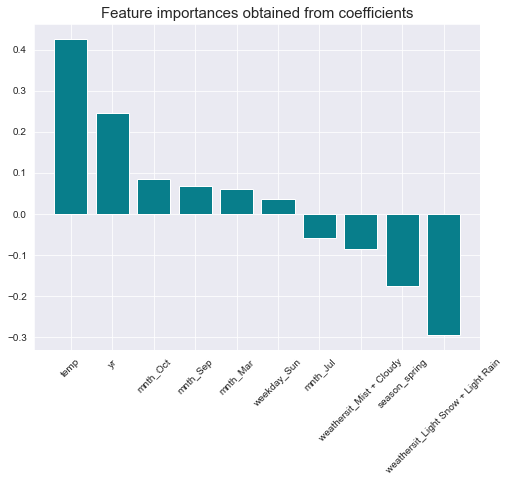

In [85]:
importances = pd.DataFrame(data={
    'Attribute': X_train_rfe.columns,
    'Importance': model6.params[1:]
})

importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=15)
plt.xticks(rotation=45)
plt.show()

# Residual Analysis for Linear Regression Assumptions

### Normally Distributed Error Terms

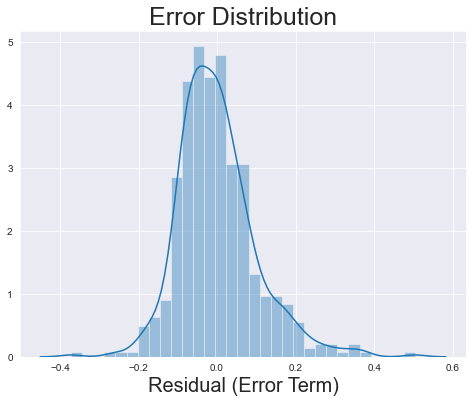

In [86]:
y_train_pred = model6.predict(X_train_sm)
residual = y_train_pred - y_train

plt.figure(figsize=(8,6))
sns.distplot(residual)
plt.xlabel('Residual (Error Term)', fontdict={'fontsize': 20})
plt.title('Error Distribution', fontdict={'fontsize': 25})
plt.show()

It is evident that Error Distribution Is Normally Distributed around 0, which indicates that our model has handled the assumption of Error Normal Distribution properly

### Error Terms are Independent

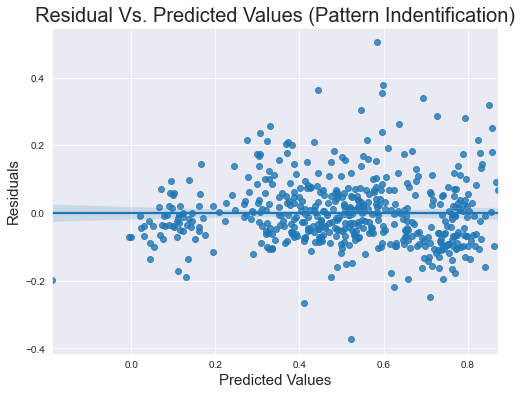

In [87]:
plt.figure(figsize=(8,6))
sns.regplot(x=y_train_pred, y=residual)
plt.title('Residual Vs. Predicted Values (Pattern Indentification)', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

From the above graph, we see that there is no specific pattern between Residual & Predicted Value. This shows that the error terms are independent

### Homoscedasticity

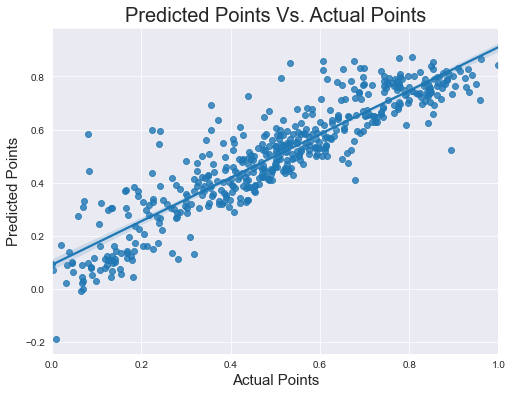

In [88]:
plt.figure(figsize=(8,6))
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

From the above graph, we can say that residuals are equal distributed across predicted value.
This means there is equal variance and we do NOT observe high concentration of data points in any particular region.
This proves Homoscedasticity of Error Terms

# Predicting on Test Data

In [89]:
# Scaling the numerical features in the test dataset based on the fit performed on train dataset

df_test[num_features] = scaler.transform(df_test[num_features])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow + Light Rain,weathersit_Mist + Cloudy
469,1,0,1,0.682257,0.354276,0.507795,0.809006,0,1,0,...,0,0,1,0,0,0,0,0,0,0
149,0,1,0,0.840090,0.601512,0.272594,0.442714,0,1,0,...,0,0,0,0,0,0,0,1,0,0
303,0,0,1,0.349977,0.627108,0.210290,0.390921,0,0,1,...,1,0,0,0,0,0,0,1,0,0
356,0,0,0,0.391512,0.603257,0.630818,0.214657,1,0,0,...,0,0,0,0,1,0,0,0,0,0
516,1,0,0,0.741445,0.699825,0.538938,0.446215,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [90]:
df_test[num_features].describe()

,temp,hum,windspeed,cnt
count,219.000000,219.000000,219.000000,219.000000
mean,0.526095,0.506179,0.436568,0.466944
std,0.231022,0.201082,0.207339,0.227788
min,0.047675,-0.092496,0.049875,-0.049378
25%,0.337517,0.353402,0.301424,0.276892
50%,0.504695,0.489819,0.406533,0.463962
75%,0.734695,0.629726,0.532728,0.610769
max,0.970925,1.002908,1.214955,0.980804


### Creating X and y in Test Set

In [91]:
y_test = df_test.pop('cnt')
X_test = df_test

In [92]:
# Selecting the variables that were part of final model

X_test = X_test[X_train_rfe.columns]

# Adding constant to test set
X_test_sm = sm.add_constant(X_test)

In [93]:
# Making predictions using the final model

y_pred = model6.predict(X_test_sm)

# Model Evaluation

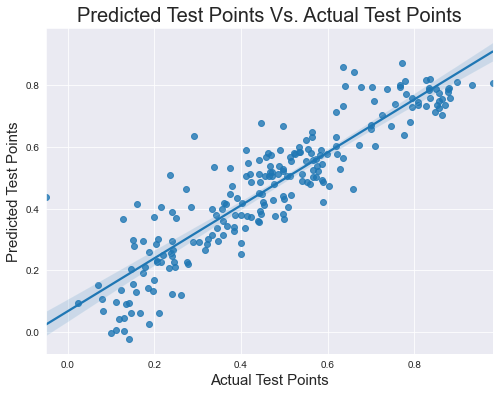

In [94]:
plt.figure(figsize=(8,6))
corr_plot = sns.regplot(x=y_test, y=y_pred)
plt.title('Predicted Test Points Vs. Actual Test Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Test Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Test Points', fontdict={'fontsize': 15})
plt.show()

From the above graph, we can see that there is a linear relationship between predicted and actual test points

### Evaluation metrics

#### R-squared

In [95]:
# Calculating R-squared using sklearn's r2_score

r2 = r2_score(y_test, y_pred)
r2

0.8095921802453199

#### Adjusted R-squared

In [96]:
# n is number of rows in X
n = X_test.shape[0]


# Number of features is the shape along axis 1
p = X_test.shape[1]

# We find the Adjusted R-squared using the formula

adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.8004379581417295

#### Root Mean Squared Error

In [97]:
# Calculating RMSE by taking square root of sklearn's mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

0.09917000217409237

The R-squared value for training set is .819. The corresponding Adjusted R-squared value is .816

We can see that the R-squared and Adjusted R-squared on the test dataset is .809 and .800

As such, we can conclude that the model is able to generalize well and predict the count of riders pretty well. 

Additionally we can see that the RMSE value is .09. This signifies that the model is performing very well

# Recommendation based on our model

As per our final Model, the top 3 predictor variables that influences the bike booking are: 
- **Temperature (temp)** - A coefficient value of 0.4265 indicates that a unit increase in temp variable keeping other variables constant increases the bike hire numbers by 0.4265 units. 
- **Weather - Light Snow + Light Rain** - A coefficient value of -0.2961 indicates that a unit increase in weathersit_Light Snow + Light Rain variable keeping other variables constant decreases the bike hire numbers by 0.2961 units.
- **Year (yr)** - A coefficient value of 0.2462 indicates that a unit increase in yr variable keeping other variables constant increases the bike hire numbers by 0.2462 units. 

#### So, it's recommended to consider these variables of utmost importance while planning, to achieve maximum Booking